### Imports

In [1]:
from jaxflows.flows import NeuralSplineFlow
from jaxflows.train_utils import train_flow

import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
import jax.numpy as jnp
from jax import random
from rnpe.denoise import horseshoe_denoiser_model
from numpyro.infer.hmc import NUTS
from numpyro.infer.mcmc import MCMC


/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


### Create toy dataset

In [2]:
n_samples = 10000
scaler = preprocessing.StandardScaler()
x, _ = datasets.make_moons(n_samples=n_samples, noise=0.05)
x = scaler.fit_transform(x)
x = jnp.array(x)

### Train flow on dataset

In [3]:
key, flow_key, train_key = random.split(random.PRNGKey(0), 3)
key, subkey = random.split(key)
flow = NeuralSplineFlow(flow_key, target_dim=x.shape[1])
flow, losses = train_flow(train_key, flow, x)

 66%|██████▌   | 33/50 [00:30<00:15,  1.07it/s, train=1.19, val=1.22]

Max patience reached.


### Denoise with MCMC

In [19]:
y_obs = jnp.array([1.7, 1.5])
kernel = NUTS(horseshoe_denoiser_model)
mcmc = MCMC(kernel, num_warmup=3000, num_samples=10000)
mcmc.run(random.PRNGKey(42), y_obs, flow.bijection.inverse)
mcmc.print_summary()

sample: 100%|██████████| 13000/13000 [00:33<00:00, 386.17it/s, 47 steps of size 2.50e-02. acc. prob=0.55]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
lambdas[0]    423.28   1969.69      6.32      0.03   1033.39     73.22      1.00
lambdas[1]    679.61   7337.38      5.04      0.00    530.47    429.68      1.00
    tau[0]      0.11      0.44      0.01      0.00      0.22   1013.18      1.00
      z[0]      0.70      0.90      1.02     -0.35      1.88     13.43      1.00
      z[1]      0.33      0.51      0.44     -0.38      1.06     82.23      1.00

Number of divergences: 3128


### Plot samples

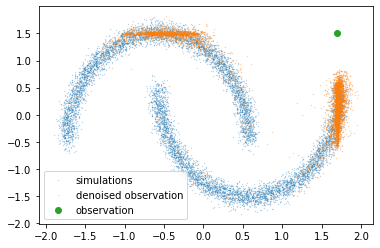

In [42]:
mcmc_samples = mcmc.get_samples()["x"]

plt.scatter(
    x[:, 0],
    x[:, 1],
    alpha=0.4,
    s=0.1, label = "simulations"
)

plt.scatter(
    mcmc_samples[:, 0],
    mcmc_samples[:, 1],
    s=0.1,
    label="denoised observation",
    alpha=0.5
)

plt.scatter(
    x = y_obs[0],
    y = y_obs[1],
    label="observation",
)

plt.legend(loc="lower left")